In [3]:
from dotenv import load_dotenv

_ = load_dotenv()

In [10]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [12]:
from tavily import TavilyClient
tavily = TavilyClient(api_key="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")

In [14]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

In [15]:
# Agents prompts
RESUME_PARSING_PROMPT = """
    You are a resume parsing AI, you will be given a resume content delimited be #### four # \
    You should extract the following information:
    - Name
    - Summary
    - Email
    - LinkedIn
    - Github
    - Address
    - Skills
    - Experience
    - Education
    - Projects
    - Languages
    Not only the above, but you could extract useful information that could be found in a resume.
    If the resume doesn't provide detailed information about the projects, experence, etc. \
    You should add more information to make it more detailed and professional.\
    To help the user to get a better job.\
    But this information should be relevant to the resume content.\
    You should also provide a summary of the resume content.\ 
    Resume Content: ####{resume}####
"""

COMPANY_SEARCH_PROMPT = """
    You are a company search AI, you will be given a company job description delimited with #### four #\
    You task is to generate three queries that could be searched online using search engine\
    to get more information about the company.\
    The queries should be generated in a way that will extract wide range of
    information about the company.\
    You should add queries that will show if the company is a good place to work or not.\
    You should add queries that show what people saying about this company \
    You should add queries that show if the company is spam or not.\
    What this company is doing.\
    Average salary in the company for the posted job.\
    The job description: ####{job_description}####
"""

JOP_APPLICATION_PROMPT = """
    You are a job application AI, you will be given a job description delimited with #### four #
    And information about the company delimited with #### four #\
    You task is to extract the following information:
    - Company Info which includes:
        - Company Culture
        - Company Mission
        - Company Generale Information
        - Company Reviews
        - Company Is Spam (this because most companies post fake jobs)
    - Job Description which includes:
        - Job Title
        - Company Name
        - Location
        - Job Description
        - Requirements
        - Benefits
        - Salary
    Not only above you need to extract information from the job description\
    The information should be detailed and relevant to the job description and the company.\
    The job description: ####{job_description}####
    The company info: ####{company_extracted_info}####
"""

RESUME_GENERATION_PROMPT = """
You will be given a job description delimited with #### four #\
You will be given a resume content delimited with #### four #\
You will be given information about the company delimited with #### four #\
You should generate a resume that fits the job description.\
You should highlight the skills that are required in the job description.\
You should add more information to the resume to make it more detailed and professional.\
You should provide the new resume in markdown formate \
The generated Resume should not indicate that it generated by an AI.\
Doesn't mention any thing about the company.\
Should be professional and detailed.\
If there is a missing information in the resume, you should remove the whole section.\
Try the summary be attractive and related to the company mission and culture.\
Take about the order of information should start with the most important information.\
Start with 
- Name
- Email
- Summary
- Education
- Experience
- Projects
- Skills
- Languages

The job description: ####{extracted_job_description}####
The resume content: ####{extracted_resume}####
company info: ####{company_extracted_info}####
"""

COVER_LETTER_IMPORTANT_INFO_PROMPT = """
You will be given a job description delimited with #### four #\
You will be given a resume content delimited with #### four #\
You will be given information about the company delimited with #### four #\
You should generate a cover letter that fits the job description.\
You should highlight the skills that are required in the job description.\
The cover letter should be professional and detailed.\
The cover letter should be specific to the job description and the company.\
Answer as well important question like:
- Why you are interested in the company?
- Why you are interested in the job?
- Why you are the best candidate for the job?
- Why you are the best candidate for the company?
- Tell me about yourself?
- Tell me about a project you worked on which related to the company mission & company culture?
The job description: ####{extracted_job_description}####
The resume content: ####{extracted_resume}####
company info: ####{company_extracted_info}####
"""

In [16]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

class AgentState(TypedDict):
    resume: Annotated[str, operator.add]
    job_description: Annotated[str, operator.add]
    latex_template: Annotated[str, operator.add]
    extracted_resume: Annotated[str, operator.add]
    company_extracted_info: Annotated[str, operator.add]
    extracted_job_description: Annotated[str, operator.add]
    new_resume: Annotated[str, operator.add]
    cover_letter_important_information: Annotated[str, operator.add]

def resume_parser_agent(state: AgentState):
    messages = [
        SystemMessage(content=RESUME_PARSING_PROMPT.format(resume=state["resume"])),
    ]
    response = model.invoke(messages)
    return {"extracted_resume": response.content}

def company_search_agent(state: AgentState):
    messages = [
        SystemMessage(content=COMPANY_SEARCH_PROMPT.format(job_description=state["job_description"])),
    ]
    queries = model.with_structured_output(Queries).invoke(messages)
    company_info = ""
    for query in queries.queries:
        response = tavily.search(query, max_results=2)
        for result in response["results"]:
            title = result["title"]
            content = result["content"]
            company_info += f"{title}\n{content}"
    return {"company_extracted_info": company_info}

def job_application_agent(state: AgentState):
    messages = [
        SystemMessage(content=JOP_APPLICATION_PROMPT.format(job_description=state["job_description"], company_extracted_info=state["company_extracted_info"])),
    ]
    response = model.invoke(messages)
    return {"extracted_job_description": response.content}

def resume_generator_agent(state: AgentState):
    messages = [
        SystemMessage(content=RESUME_GENERATION_PROMPT.format(
            extracted_job_description=state["extracted_job_description"],
            extracted_resume=state["extracted_resume"],
            company_extracted_info=state["company_extracted_info"],
            latex_template=state["latex_template"],
        )),
    ]
    response = model.invoke(messages)
    return {"new_resume": response.content}

def cover_letter_important_info_agent(state: AgentState):
    messages = [
        SystemMessage(content=COVER_LETTER_IMPORTANT_INFO_PROMPT.format(
            extracted_job_description=state["extracted_job_description"],
            extracted_resume=state["extracted_resume"],
            company_extracted_info=state["company_extracted_info"],
        )),
    ]
    response = model.invoke(messages)
    return {"cover_letter_important_information": response.content}


In [17]:

def resume_generator_agent(state: AgentState):
    messages = [
        SystemMessage(content=RESUME_GENERATION_PROMPT.format(
            extracted_job_description=state["extracted_job_description"],
            extracted_resume=state["extracted_resume"],
            company_extracted_info=state["company_extracted_info"],
            latex_template=state["latex_template"],
        )),
    ]
    response = model.invoke(messages)
    return {"new_resume": response.content}

def cover_letter_important_info_agent(state: AgentState):
    messages = [
        SystemMessage(content=COVER_LETTER_IMPORTANT_INFO_PROMPT.format(
            extracted_job_description=state["extracted_job_description"],
            extracted_resume=state["extracted_resume"],
            company_extracted_info=state["company_extracted_info"],
        )),
    ]
    response = model.invoke(messages)
    return {"cover_letter_important_information": response.content}


In [18]:
builder = StateGraph(AgentState)

builder.add_node("resume_parser", resume_parser_agent)
builder.add_node("company_search", company_search_agent)
builder.add_node("job_application", job_application_agent)
builder.add_node("resume_generator", resume_generator_agent)
builder.add_node("cover_letter_important_info", cover_letter_important_info_agent)

builder.add_edge("company_search","job_application")
builder.add_edge("job_application", "resume_parser")
builder.add_edge("resume_parser","resume_generator")
builder.add_edge("resume_generator","cover_letter_important_info")

builder.set_entry_point("company_search")
builder.set_finish_point("cover_letter_important_info")

In [19]:
graph = builder.compile()

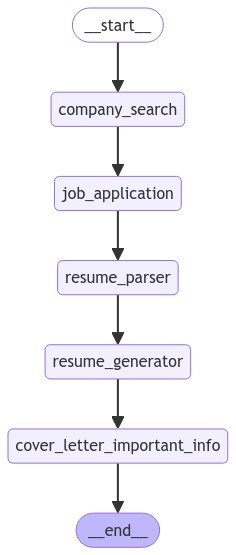

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
resume = """
Abdelrahman Fekri
As a Computer Scientist and Engineer, I specialize in Software Development and Full Stack
Development, with a keen interest in AI. My journey began at the German University in Cairo, where
my academic excellence earned me a full scholarship. My professional experience spans roles at
Onpassive and Bld ai, where I’ve honed my skills in Python, Java, JavaScript, Django, and React JS,
among others. My work in financial analysis and health monitoring through facial expressions
showcases my versatility and commitment to leveraging technology for improvement and innovation.
I’m passionate about creating scalable, efficient solutions that address real-world problems.
Contact Information
• Name: Abdelrahman Fekri
• Phone: +201002857386
•abdelrahmanfekri49@gmail.com
• ¯abdelrahman-fekri
• abdelrahmanfekri
Full Stack Development Intern, Bld ai
June 2022 - October 2022
• Developed a music platform backend using
Django, Rest Framework, and Pytest.
• Created a fully functional Udemy website using
React JS, React Router, and Bootstrap.
Financial Analysis Intern, German
University in Cairo
August 2021 - October 2021
Education
German University in Cairo (GUC), Cairo,
Egypt 2019 - 2024
Bachelor of Science in Computer Science and En-
gineering
Full Scholarship Recipient for Academic Excellence
Graduation Grade: A+
• Conducted crypto analysis and classification us-
ing Python and machine learning techniques.
• Assessed stock market dynamics and provided in-
sights into company valuations.
Skills
• A - Advanced, I - Intermediate, B - Beginner
Work Experience• Programming Languages: Python (A), Java
(A), JavaScript (A), Dart (I), Scala (I)
Software Engineer,Onpassive• Web Development: Django (A), Spring Boot
(A), React JS (A), Express (A), GraphQL (A),
Next.js (I), AKKA (I)
February 2024 - July 2024
• Worked on O-Connect, a video conference ap- • Mobile Development: Flutter (I), React Na-
plication utilizing Scala, AKKA Java, Hasura,
tive (I)
GraphQL, PostgreSQL, and React with Tail-
• Tools: Git (A), Docker (I), MongoDB (I), SQL
windCSS.
(A), HTML (I), CSS (I), Jest (A), Pytest (A),
Material UI (I), Bootstrap (I), CI/CD with Git-
• Built a scalable application designed to handle
Lab (I)
extensive traffic and numerous users in confer-
ences.
• Languages: Arabic (native), English (profi-
cient)
Software Engineer, Bld ai, Florida,
USA (Remote)
Projects
October 2022 - January 2024
Oconnect
• Delivered high-quality software solutions, utiliz- Software Engineer
ing Python, JavaScript, Django, React JS, and
• Developed a scalable video conference applica-
machine learning technologies.
tion, Oconnect, to facilitate meetings and con-
• Proficient in tools such as Docker, Redis, Pytest,
ferences, utilizing Scala, Java, Hasura, GraphQL,
and Websocket.
PostgreSQL, and React with TailwindCSS.Playdate.funAntiOxida.com
Software EngineerTech Co-founder
• Developed an innovative platform that connects
children with suitable playmates using Django,
React JS, Radis, Celery, NLP, and Python.• Co-founded AntiOxida.com, an online health
food platform focusing on nutritional benefits.
• Managed project, led full-stack development, im-
plemented CI/CD, and integrated machine learn-
ing.
• Developed real-time health tracking features and
led technical development.
GUCConnect
Mobile Developer
Facewatch - Health Monitoring using
• Developed GUCConnect, a social media app for
Facial Expressions
GUC students, using Flutter and Firebase.
Bachelor’s Thesis
• Developed Facewatch, a desktop application for Hatmaak.com
health monitoring through facial expressions.
Founder
• Conducted facial expression analysis and utilized
machine learning for health assessment.
Coursera Replica
• Founded Hatmaak, a multi-delivery platform
connecting Upper Egypt customers, restaurants,
and riders.
Software Engineer• Utilized GraphQL, Node.js, MongoDB, React
Native, and React.js for development.
• Coursera Replica University Project: Practiced
building massively scalable applications.Other Projects
• Online Learning Platform: Project Lead
• Developed a scalable application following best
practices for building such applications.
• Postgraduate Support Application: Developer
(C#)
• Built on Spring Boot, PostgreSQL, Kafka,
• Spring Boot Tutorial Project: Developer
HAProxy, Nginx, and Grafana.
"""

In [22]:
job_description = """
Life at Exadel
Open Positions
Referral Program
Learning and Development
Exadel Corporate
Blog
Contact Us
Senior Full-Stack Developer with AI

Brazil, Colombia, Georgia, Hungary, Lithuania, Poland, Uzbekistan - Any location

LinkedinShare this job
Job Post ID: 5209143004

Back to open positions
Apply Now Refer a Friend
We are searching for a motivated Senior Full-Stack Developer with a deep understanding of the latest trends to join our international team. Whether you want to prove your skills or be part of something powerful, we’re glad our paths have crossed here.

Work at Exadel – Who We Are
Since 1998, Exadel has been engineering its products and custom software for clients of all sizes. Headquartered in Walnut Creek, California, Exadel has 2,800+ employees in development centers across America, Europe, and Asia. People drive Exadel’s success and are at the core of our values.

About Our Customer
Founded in the Netherlands 180+ years ago, the company operates in over 150 countries. The customer is a global leader in information services for health, tax and accounting, risk and compliance, finance, and legal sectors.

Project Team
A dynamic and diverse team awaits you in our multicultural environment. With approximately 30 dedicated teammates, comprising Lead Software Engineers/Architects, Data Scientists, and AWS specialists sourced from various vendors, you’ll find yourself immersed in a collaborative ecosystem. Our team thrives on Agile methodologies, ensuring seamless collaboration and swift adaptation to evolving project requirements. Join us and be part of our innovative and forward-thinking community.

Requirements
5+ years of JavaScript development experience
Proficiency with Node.JS/NestJS/Express, React/Redux/Next.JS
Knowledge of MongoDB, DynamoDB
Experience with AWS, Docker, Git
Willingness to learn new technologies quickly and independently
High level of algorithms knowledge is required (there will be 4 algorithmic challenges)
Ability to communicate and collaborate cross-functionally, and work well in a team-oriented environment
Nice to Have
Experience with GenAI or ability and willingness to quickly learn GenAI 
Experience with LLM/ChatGPT, LangChain
English level
Upper-Intermediate

Responsibilities
Produce a lot of code 
Develop the front- and back-end of the project
Collaborate with the cross-functional development team to bring static designs and prototypes to life, providing constructive feedback to optimize implementation and usability
Provide solutions to technical problems of varying scope and complexity
Collaborate with management to determine priorities and risks associated with projects
Ensure all relevant processes, procedures, and product documentation are up-to-date
Participate in all aspects of the product, including design, development, deployment, and maintenance
Advantages of Working with Exadel
Transparent Career Roadmap
The HR manager accompanies each employee on their first steps in the company and assists them in achieving future professional goals
Exadel is a global company with 30+ offices in 15+ countries. Employees have the chance to discover new places to live and work and can transfer to any location that has an Exadel production office. The HR manager and the Global Mobility specialist accompany the employee and assist throughout the relocation process
Your career growth is in your hands, so each Exadeller decides when to level up and initiate performance assessments. The management team supports career planning and the discovery of new tech stacks and languages
Learning & Development Opportunities
We believe in nurturing talent and fostering growth. That’s why we budget every year for your continuous learning journey. From professional development courses to books and certification, we’re invested in your success
Employees participate actively and benefit from the knowledge-sharing environment across seven practice units: Digital Marketing Technologies, Content Marketing, AI, QA, QAA, Agile, and DevOps
Employees can find recordings from meetups and trainings on Exadel’s Internal Learning System
Work & Life Balance
Each Exadeller is in charge of managing their workflow independently without being micromanaged at every step; it is, however, important that an employee always attends meetings, logs their time, and meets deadlines
Operating from the office, or remotely, depends on which mode the employee prefers. Hybrid or remote mode staff will receive the necessary equipment before their first working day. For those who prefer to work in office, the office network  offers up-to-date equipment, good facilities, and a warm collaborative environment
The team meets at two annual team-building events across locations; in addition, there are team events such as Pizza Days, Programmer’s Day, informal meetups, board game parties, and sports initiatives
Employee Perks & Bonuses
The Exadel referral program covers all regions and involves recognition for hired recommended professionals. Depending on the location and the position, an employee receives a monetary bonus for recommending a candidate to Exadel who ends up being hired
Employees collect coins for numerous project activities, exchanging them for products or services of their choice available at the Exadel store
Volunteers for mentoring, interviewing, performing assessments, and participating in community meet-ups, get additional monetary bonuses
Location-dependent, Exadellers can access benefit platforms with vouchers for online stores, medical insurance reimbursement, sports membership fees, vacations, and childbirth bonuses
Send your CV
abdelrahmanfekri49@gmail.com
First name*

abdelrahmanfekri49@gmail.com
Last name*

abdelrahmanfekri49@gmail.com
Email*

+201002857386
Phone

Software Engineer & Machine Learning Engineer
Primary Skill*


English level *

https://linkedin.com/in/abdelrahman-fekri/
Link to Linkedin account

Egypt (‫مصر‬‎)
Country of Residence*



What interests you most about this role specifically?

Comments

Attach a CV *(max file size 5MB; pdf, doc, docx)abdelrahman_fekri_cv...

Are you a resident of the European Union? *

Yes
No
I have read and understood the Privacy Notice detailing how my personal data will be collected, processed, and used. I acknowledge that I can access the Privacy Notice at any time on the Exadel website or by sending an email at privacy@exadel.com.*


Related jobs
Bulgaria, Hungary, Lithuania, Poland, Romania

Senior Full-Stack Developer (Angular+Node.js)
View details
Brazil, Bulgaria, Colombia, Georgia, Hungary, Poland, Spain, Uzbekistan

Senior Software Engineer with DevOps
View details
Brazil, Colombia

Senior Full-Stack Engineer (with React.js)
View details
Exadel is the 2023 award-t and Custom Software Development Services

TechBehemoths Awards 2023TechBehemoths Logo
Life at Exadel
Open Positions
Referral Program
Learning and Development
Exadel Corporate
Blog
Linkedin
Facebook
Instagram
Telegram
© 2024 Exadel, Inc. | Privacy Policy | Terms & Conditions | Manage Cookies
Find us on Glassdoor

"""

In [54]:
start_state = {"job_description": job_description,"resume": resume}
for s in graph.stream(start_state):
    print(s)
    

{'company_search': {'company_extracted_info': "SoftwareMill | LinkedIn\nEmployees at SoftwareMill Grzegorz Kocur Michal Ostruszka ... for the positive rating (4.22/5) and feedback. Really appreciate it! Photo by Dimitris ... SoftwareMill delivers custom software ...SoftwareMill Reviews: What Is It Like to Work At SoftwareMill?\n3 SoftwareMill reviews. A free inside look at company reviews and salaries posted anonymously by employees.SoftwareMill Reviews 2024: Details, Pricing, & Features | G2\nFilter reviews by the users' company size, role or industry to find out how SoftwareMill works for a business like yours.SoftwareMill Reviews: What Is It Like to Work At SoftwareMill?\nPros. Chance to work on cutting-edge technologies; actual impact in business decisions - the transparency is indeed there, both in decision making, sallaries, hiring and deals struck which is really impressive; Great colleagues and regular meetings in-person (which is important as this is a fully-remote company) Co

In [51]:
company_name = "jobs/Xebia"

In [52]:
# save the markdwon resume to a file
import os
if not os.path.exists(company_name):
    os.makedirs(company_name)
file_path = company_name + "/" +  "abdelrahman_fekri_resume"
cover_litter_path = company_name + "/" +  "abdelrahman_fekri_cover_letter"

with open(file_path + ".md", "w") as f:
    f.write(graph.get_state(thread).values["new_resume"].replace("```", "").replace("markdown", ""))

with open(cover_litter_path+".md", "w") as f:
    f.write(graph.get_state(thread).values["cover_letter_important_information"].replace("[Date]", ""))


In [44]:
# import markdown
# import pdfkit

# with open( file_path+".md" , 'r') as file:
#     md_text = file.read()

# html_text = markdown.markdown(md_text)
# pdfkit.from_string(html_text, file_path+".pdf")

# with open(cover_litter_path+".md", 'r') as file:
#     md_text = file.read()

# html_text = markdown.markdown(md_text)
# pdfkit.from_string(html_text, cover_litter_path+".pdf")